# Setup

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
from sparse_field_lib import load_data

In [4]:
import matplotlib.pyplot as plt
import sklearn
import torch

from bliss.datasets import sdss
from bliss.models import encoder, decoder
from bliss import sleep

from astropy.table import Table

In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

import plotly.express as px
import plotly.graph_objects as go

In [7]:
# where is the sdss data? 
sdss_dir = '/home/imendoza/bliss/data/sdss/'

In [8]:
# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

5


## Utility Functions

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def imshow_cbar(fig, ax, image, vmin=None, vmax=None, s=20): 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(image, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=s)

# Load data

In [10]:
sdss_data = sdss.SloanDigitalSkySurvey(
    sdss_dir=sdss_dir,
    run=94,
    camcol=1,
    fields=(12,),
    bands=range(5),
    overwrite_cache=True,
    overwrite_fits_cache=True,
)

In [11]:
frame, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir)
frame_fits = Table(sdss_data[0]['po_fits'])
print("# objects detected by photo on frame: ", len(frame_fits))
print("# objects detected by photo on coadd: ", len(fits_file['ra'][:]))
frame = frame[0].numpy()
print(frame.shape)

# objects detected by photo on frame:  999
# objects detected by photo on coadd:  901
(1489, 2048)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [12]:
wcs = wcs_list[0]
pt, pr = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)
pt_frame, pr_frame = wcs.all_world2pix(frame_fits['RA'].reshape(-1), frame_fits['DEC'].reshape(-1), 0)
is_star = fits_file['probpsf'][:].astype(bool)

# remove all locations that are not inside the image. 
keep = (pt > 0) & (pt < frame.shape[1]-1) & (pr > 0) & (pr < frame.shape[0]-1)
pt = pt[keep]
pr = pr[keep]
is_star = is_star[keep]

keep_frame = (pt_frame > 1) & (pt_frame < frame.shape[1]-1) & (pr_frame > 1) & (pr_frame < frame.shape[0]-1)
pt_frame = pt_frame[keep_frame]
pr_frame = pr_frame[keep_frame]

# Prepare model

In [13]:
# prepare BLISS model 
checkpoint_file = '/home/imendoza/bliss/models/sleep_sdss_measure.ckpt'
sleep_net= sleep.SleepPhase.load_from_checkpoint(checkpoint_file).to(device)
image_encoder = sleep_net.image_encoder
galaxy_encoder = sleep_net.galaxy_encoder

# important to turn on .eval() mode!
sleep_net = sleep_net.eval()
sleep_net.galaxy_encoder.eval()
image_encoder = image_encoder.eval()

# Loop over chunks

In [16]:
import copy

h,w = frame.shape # full frame size.

cp = image_encoder.border_padding # chunk padding 
clen = 300 # chunk slen (square).
cplen = clen + cp*2 # padded chunk slen. 

ihic = h // clen # image height in chunks
iwic = w // clen # image width in chunks

locs = torch.tensor([])
galaxy_bool = torch.tensor([])

pt1 = copy.deepcopy(pt)
pr1 = copy.deepcopy(pr)

keep = np.zeros((len(pt1))).astype(bool)

with torch.no_grad():
    for i in range(iwic):
        for j in range(ihic):
            print(i,j)
            x1,y1 = i*clen + cp, j*clen + cp
            pchunk = frame[y1 - cp: y1 + clen + cp, x1 - cp: x1 + clen + cp]
            assert pchunk.shape == (cplen, cplen)
            pchunk = pchunk.astype(np.float32)
            pchunk = torch.from_numpy(pchunk).to(device).reshape(1, 1, cplen, cplen)
            
            # get estimates with BLISS trained model. 
            tile_est = sleep_net.tile_images_map_estimate(pchunk)
            est_params = encoder.get_full_params(tile_est, clen)
            
            _locs = est_params['locs'].cpu()
            _galaxy_bool = est_params['galaxy_bool'].cpu().reshape(-1, 1)
            
            _locs = _locs.reshape(-1, 2)
            x, y = _locs[:, 1].reshape(-1, 1), _locs[:, 0].reshape(-1, 1)
            x = x*clen + x1 - 0.5 
            y = y*clen + y1 - 0.5 # pixels, same format as pt,pr
            locs1 = torch.hstack((x,y)).reshape(-1, 2).cpu()
            locs  = torch.cat((locs, locs1))
            
            _galaxy_bool = _galaxy_bool.reshape(-1, 1)
            galaxy_bool = torch.cat((galaxy_bool, _galaxy_bool))
            
            # remove centroids from true photo in padding
            keep1 = (pt1 > x1) & (pt1 < x1+clen) & (pr > y1) & (pr < y1+clen)
            keep = keep | keep1

            # delete extra stuff in GPU and clear cache for next iteration.
            del pchunk
            del tile_est
            del est_params
            torch.cuda.empty_cache()

pt1, pr1 = pt1[keep], pr1[keep]
is_star1 = is_star[keep]
locs = locs.numpy()
galaxy_bool = galaxy_bool.numpy()

0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
5 0
5 1
5 2
5 3

536 423


In [17]:
# how many objects are left? 
print(len(pt1), len(locs))

536 423


# Visualize Frame

In [65]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.imshow(frame, zmin=800, zmax=1100)

scatter_true = go.Scatter(name='true', x=pt1, y=pr1, mode='markers', marker=dict(color='red', size=8, symbol='x'))
scatter_est = go.Scatter(name='est', x=locs[:, 0], y=locs[:, 1], mode='markers', marker=dict(color='blue', size=8, symbol='x'))

fig.add_trace(scatter_true)
fig.add_trace(scatter_est)

fig.update_layout(width=1000, height=750)
fig.update_layout(legend=dict(orientation="h", y=1.02))




# Match objects

In [48]:
from bliss.metrics import inner_join_locs
_plocs = torch.from_numpy(np.hstack((pt1.reshape(-1, 1), pr1.reshape(-1, 1))))
_locs = torch.from_numpy(locs)
_galaxy_bool = torch.from_numpy(galaxy_bool)

# do matching
_plocs, _locs, row_indx, col_indx = inner_join_locs(_plocs, _locs)

#only keep match if l_{inf} < 1 pixel away. 
dist = (_plocs - _locs).abs().max(1)[0]
keep_match = dist < 1.0

_plocs = _plocs[keep_match].numpy()
_locs = _locs[keep_match].numpy()

# need to apply it to galaxy bool as well.
_galaxy_bool = _galaxy_bool[col_indx][keep_match].reshape(-1).numpy().astype(bool)
_is_star = is_star1[row_indx][keep_match].reshape(-1).astype(bool)

# Metrics

In [20]:
# precision and recall 

tp = sum(keep_match) # true positives = # of objects matched with a true object. 
fp = sum(~keep_match) # false positives = detected object not matched with true object.

# precision 
# recall = tp / total # of true objects
precision = (tp / (tp + fp)).item()
recall = (tp / len(pt1)).item()
f1 = (2 * precision * recall) / (precision + recall)

print(f'precision: {precision:.3f}')
print(f'recall: {recall:.3f}')
print(f'f1: {f1:.3f}')


precision: 0.740
recall: 0.584
f1: 0.653


In [44]:
# confusion matrix for star vs galaxy classification
from sklearn.metrics import confusion_matrix
confusion_matrix(~_is_star, _galaxy_bool, labels=[True, False]) # True == Galaxy

array([[ 38, 103],
       [  3, 169]])

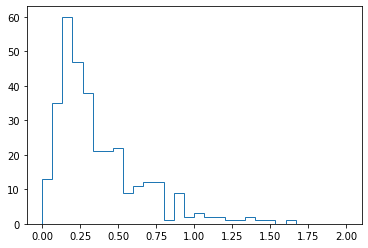

In [54]:
# histogram of mse between matching locations 
%matplotlib inline
plt.hist(dist.numpy(), bins=30, range=(0, 2.0), histtype='step');